In [1]:
#used packages
import torch
import json
################################1. preparing the utilities functions to process our data
#Here we define the utilities function to process our data, i.e. nodes and edges and thier features (attributes)
#For representing this data in the PyG data format, we first define a method load_node_csv() that reads 
#in a *.csv file and returns a node-level feature representation x of shape [num_nodes, num_features]:

###############################1.1 function to Load node-realted data
#load_node_csv() reads the *.csv file from path, and creates a dictionary mapping that maps its index column 
#to a consecutive value e.g., the representation of a resource in the first row should be accessible via x[0].

def load_node_csv(path, mapping, encoders=None, **kwargs):
    x_mapping = {}
    df = pd.read_csv(path, index_col="resourceid", **kwargs)
    
    # Update x_mapping with unique node IDs, excluding "None"
    for index in df.index.unique():
        if index != "None":
            x_mapping[index] = len(x_mapping)
    
    # Update mapping dictionary with unique node IDs, excluding "None"
    unique_ids = df.index.unique()
    for node_id in unique_ids:
        if node_id != "None" and node_id not in mapping:
            mapping[node_id] = len(mapping)
    
    # Create indices tensor
    indices = torch.tensor([mapping[node_id] for node_id in unique_ids if node_id != "None"])
    
    x = None
    if encoders is not None:
        xs = [encoder(df.loc[df.index != "None", col]) for col, encoder in encoders.items()]
        x = torch.stack(xs, dim=1)

    return x, x_mapping

################################################2.2 function to Load edge-related data
#loading of edges 
#load_edge_csv() returns the final edge_index representation of shape [2, number_of_each_edges_types] 
#from *.csv

def load_edge_csv(path, src_mapping, dst_mapping, encoders=None, **kwargs):
    # Read the CSV file
    df = pd.read_csv(path, **kwargs)
    # Assuming the first column is the source index column and the second is the destination index column
    src_index_col = df.columns[0]
    dst_index_col = df.columns[1]
    src = []
    dst = []
    valid_rows = []

    # Map source and destination indices using provided mappings, skipping "None"
    for i, (src_index, dst_index) in enumerate(zip(df[src_index_col], df[dst_index_col])):
        if src_index != "None" and dst_index != "None":
            src.append(src_mapping[src_index])
            dst.append(dst_mapping[dst_index])
            valid_rows.append(i)
    
    # Create edge_index tensor
    edge_index = torch.tensor([src, dst], dtype=torch.long)
    edge_attr = None
    if encoders is not None:
        edge_attrs = [encoder(df.loc[valid_rows, col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr


################################################1.3 function to define an encoder that applies on of NLP model to encode node/edgae related features 
from sentence_transformers import SentenceTransformer
class SequenceEncoder(object):
    def __init__(self, model_name='all-MiniLM-L6-v2', device=None):
        self.device = device
        self.model = SentenceTransformer(model_name, device=device)

    @torch.no_grad()
    def __call__(self, df):
        x = self.model.encode(df.values, show_progress_bar=True,
                              convert_to_tensor=True, device=self.device)
        return x.cpu()


class ProviderEncoder(object):
    def __call__(self, df):
        tensor_val=torch.tensor(df.values,dtype=torch.float)

        return tensor_val.cpu()
class TypeEncoder(object):
    def __call__(self, df):
        tensor_val=torch.tensor(df.values,dtype=torch.float)

        return tensor_val.cpu()

class LocationEncoder(object):
    def __init__(self, dtype=None):
        self.dtype = dtype

    def __call__(self, df):
        tensor_val=torch.tensor(df.values,dtype=torch.float)

        return tensor_val.cpu()

def load_labels(path):
##load the labels of services
      with open(path) as f:
        labels = json.load(f)
      return labels 
########################2) Load the data from the given dataset using the defined utilities functions

#steps:
#A) load graphs from CSV files 
from torch_geometric.data import download_url, extract_zip
import pandas as pd
from torch_geometric.data import HeteroData
from torch_geometric.loader import DataLoader
import os
def load_data(dir_path,labels,service_label,mapping):

  providers = os.listdir(dir_path)
  data_set = []
  graph_i=0
  for provider in providers:
          services=os.listdir(dir_path+'/'+provider)
          for service in services:
                     service_files=os.listdir(dir_path+'/'+provider+'/'+service)
                     path=dir_path+'/'+provider+'/'+service+'/'
                     resource_path = path+'nodes.csv'
                     #1) load nodes
                     resource_x,mapping_x = load_node_csv(
                     resource_path, mapping, encoders={
                      'type': TypeEncoder(), 
                      'provider':ProviderEncoder()
                       
                       })
                      #initialize our HeteroData object and pass the node type into it
                     data= HeteroData()
                     data['resource'].x = resource_x
                                #2 load edges
                     for file in service_files:
                            if ('.csv' in file) and (file!='nodes.csv'):
                                    edge_path=path+file
                                    edge_index_relationship, edge_label_relationship= load_edge_csv(
                                    edge_path,
                                    src_mapping=mapping_x,
                                    dst_mapping=mapping_x,
                                    encoders=None,)  
                                    relation_name=file.replace('.csv', '')
                                    if edge_index_relationship.size(1)!=0:
                                        data['resource', relation_name, 'resource'].edge_index =  edge_index_relationship
                     data.y=torch.tensor(int(labels[provider+'_'+service_label]), dtype=torch.long) 
                     data_set.append(data)

                     graph_i+=1


  return data_set

In [4]:
#Generate training data
import random
import os
##Put here the path of dataset
current_folder = 'C:/env/'
mapping={}
label_path = os.path.join(current_folder, 'Heterogeneous_Graph_Learning/dataset/service_labels.json')
labels=load_labels(label_path)
#dir_path=r'Heterogeneous_Graph_Learning/dataset/services/'
dir_path=os.path.join(current_folder,'Heterogeneous_Graph_Learning/dataset/services/')

#will generate dataset for each service so that we can organize the finale dataset into training and testing in a fair way
L2B_graphs_path =dir_path+'L2bridging'
L2C_graphs_path =dir_path+'L2Connectivity'
L2E_graphs_path =dir_path+'L2endpoint'
L3R_graphs_path =dir_path+'L3routing'
NIC_graphs_path =dir_path+'NIC'
#Peering_graphs_path =dir_path+'peering_services' (Removed for now)

L2B_services=load_data(L2B_graphs_path,labels,'L2bridging',mapping)#
L2C_services=load_data(L2C_graphs_path,labels,'L2Connectivity',mapping)#
L2E_services=load_data(L2E_graphs_path,labels,'L2endpoint',mapping)#
L3R_services=load_data(L3R_graphs_path,labels,'L3routing',mapping)#
NIC_services=load_data(NIC_graphs_path,labels,'NIC',mapping)#
#Peering_services=load_data(Peering_graphs_path,labels)# (Removed for now)








{'aws_NIC': '0', 'azure_NIC': '1', 'aws_L2Connectivity': '2', 'azure_L2Connectivity': '3', 'aws_L2endpoint': '4', 'azure_L2endpoint': '5', 'aws_L2bridging': '6', 'azure_L2bridging': '7', 'aws_L3routing': '8', 'azure_L3routing': '9', 'aws_peering': '10', 'azure_peering': '11'}


In [4]:
#shuffling datac
random.shuffle(L2B_services)
random.shuffle(L2C_services)
random.shuffle(L2E_services)
random.shuffle(L3R_services)
random.shuffle(NIC_services)
#training
training_data_set=L2B_services[:250]+L2C_services[:250]+L2E_services[:250]+L3R_services[:60]+NIC_services[:250]
#+Peering_services[:300]
random.shuffle(training_data_set)
#testing 

testing_data_set=L2B_services[250:]+L2C_services[250:]+L2E_services[250:]+L3R_services[60:]+NIC_services[250:]
#Peering_services[300:]
random.shuffle(testing_data_set)


320
320
320
81
320
1060
301
HeteroData(
  y=7,
  resource={ x=[4, 2] },
  (resource, exposes_resource_Subnet, resource)={ edge_index=[2, 1] },
  (resource, Hosted_On_L2Domain, resource)={ edge_index=[2, 1] },
  (resource, Is_Owned_By, resource)={ edge_index=[2, 1] }
)
HeteroData(
  y=9,
  resource={ x=[8, 2] },
  (resource, exposes_resource_L3Address, resource)={ edge_index=[2, 1] },
  (resource, exposes_resource_L3SimpleRoute, resource)={ edge_index=[2, 2] },
  (resource, exposes_resource_Subnet, resource)={ edge_index=[2, 1] },
  (resource, Hosted_On_L3Domain, resource)={ edge_index=[2, 3] }
)


In [6]:
##3 Add all data into data-loader for preparing the trainning and testing 
training_loader = DataLoader(training_data_set, batch_size=16)
Testing_loader = DataLoader(testing_data_set, batch_size=16)


1060
301


In [7]:
# Hyperparameters
hidden_channels = 256
num_heads = 4
num_layers = 2
dropout_rate = 0.5
learning_rate = 1e-3
weight_decay = 1e-4
out_channels = 10  # Number of output classes




In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import HGTConv, Linear
import torch.optim as optim  # Ensure this line is included

class DynamicHGT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers):
        super().__init__()
        self.hidden_channels = hidden_channels
        self.num_heads = num_heads
        self.num_layers = num_layers

        # Define the Linear layers for the node and graph types
        self.lin = Linear(-1, hidden_channels)
        self.out_lin = Linear(hidden_channels, out_channels)
        self.lin1 = Linear(hidden_channels, hidden_channels)  # Add this line to define lin1

    def forward(self, x_dict, edge_index_dict, batch):
        # Apply Linear transformation to node features
        x_dict['resource'] = self.lin(x_dict['resource']).relu_()

        # Create HGTConv layers dynamically based on metadata
        conv_layers = torch.nn.ModuleList()
        for _ in range(self.num_layers):
            conv = HGTConv(self.hidden_channels, self.hidden_channels, batch.metadata(),
                           self.num_heads, group='sum')
            conv_layers.append(conv)

        # Apply HGTConv layers
        for conv in conv_layers:
            x_dict = conv(x_dict, edge_index_dict)

        # Node embeddings
        node_embeddings = x_dict['resource']

        # Compute graph embeddings
        num_nodes = torch.bincount(batch['resource'].batch)
        start_idx = 0
        graph_embeddings = []

        for num in num_nodes:
            graph_embeddings.append(node_embeddings[start_idx:start_idx + num].mean(dim=0))
            start_idx += num

        graph_embeddings = torch.stack(graph_embeddings)

        # Apply the additional linear layer
        graph_embeddings = self.lin1(graph_embeddings)
        graph_embeddings = F.relu(graph_embeddings)  # Optional activation

        # Final output layer
        return self.out_lin(graph_embeddings)


In [9]:
model = DynamicHGT(hidden_channels, out_channels, num_heads, num_layers)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()  # Adjust if needed

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader, HeteroData
from tqdm import tqdm
def train(loader):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    embeddings= []
    for batch in tqdm(loader):
        optimizer.zero_grad()
        batch = batch.to('cpu')
        # Forward pass
        graph_embeddings = model(batch.x_dict, batch.edge_index_dict, batch)
        # Collecting all graph-level labels
        targets = batch.y

        # Calculate loss
        loss = F.cross_entropy(graph_embeddings, targets)
        loss.backward()
        optimizer.step()
        
        # Collect predictions and labels
        _, predicted = graph_embeddings.max(dim=1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())
        
        total_loss += loss.item()

    # Convert lists to numpy arrays for metrics calculation
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    avg_loss = total_loss / len(loader)
    return avg_loss, accuracy, precision, recall, f1








In [11]:
def test(test_loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    all_preds = []
    all_labels = []
    embeddings=[]
    with torch.no_grad():  # Disable gradient calculations
        for batch in tqdm(test_loader):
            batch = batch.to('cpu')
            
            # Forward pass
            graph_embeddings = model(batch.x_dict, batch.edge_index_dict, batch)
            targets = batch.y
            
            # Calculate loss
            loss = F.cross_entropy(graph_embeddings, targets)
            total_loss += loss.item()
            
            # Collect predictions and labels
            _, predicted = graph_embeddings.max(dim=1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
            embeddings.extend(graph_embeddings)
    # Convert lists to numpy arrays for metrics calculation
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    avg_loss = total_loss / len(test_loader)
    return avg_loss, accuracy,embeddings,all_labels, precision, recall, f1


In [41]:
graph= torch.load('C:\\env\\Heterogeneous_Graph_Learning\\GNN-Model\\Augmented.pt')


In [43]:
data=training_data_set+graph+testing_data_set

In [47]:
train_size=int(0.7*len(data))
augmented_training_set=data[:train_size]
augmented_testing_set=data[train_size:]

1521
653


In [57]:
random.shuffle(data)
from torch_geometric.loader import DataLoader
augmented_testing_loader = DataLoader(augmented_testing_set, batch_size=16, shuffle=True)
augmented_training_loader = DataLoader(augmented_training_set, batch_size=16, shuffle=True)



41
96


In [61]:
for epoch in range(5):
    train_loss, train_accuracy, train_precision, train_recall, train_f1 = train(training_loader)
    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")
for epoch in range(5):
    train_loss, train_accuracy,train_embeddings,train_labels, train_precision, train_recall, train_f1 = test(training_loader)
    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")
    test_loss,test_accuracy,test_embeddings,test_labels, test_precision, test_recall, test_f1 = test(Testing_loader)
    print(f"Epoch {epoch+1} - Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.26it/s]


Epoch 1 - Train Loss: 0.2754, Accuracy: 0.8830, Precision: 0.8847, Recall: 0.8830, F1 Score: 0.8835


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.07it/s]


Epoch 2 - Train Loss: 0.2517, Accuracy: 0.8925, Precision: 0.8932, Recall: 0.8925, F1 Score: 0.8925


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.45it/s]


Epoch 3 - Train Loss: 0.2008, Accuracy: 0.9302, Precision: 0.9309, Recall: 0.9302, F1 Score: 0.9301


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.06it/s]


Epoch 4 - Train Loss: 0.2373, Accuracy: 0.8981, Precision: 0.8983, Recall: 0.8981, F1 Score: 0.8976


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.77it/s]


Epoch 5 - Train Loss: 0.2493, Accuracy: 0.8981, Precision: 0.8986, Recall: 0.8981, F1 Score: 0.8982


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 31.15it/s]


Epoch 1 - Train Loss: 0.1614, Accuracy: 0.9340, Precision: 0.9356, Recall: 0.9340, F1 Score: 0.9338


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 30.80it/s]


Epoch 1 - Test Loss: 0.1442, Accuracy: 0.9535, Precision: 0.9560, Recall: 0.9535, F1 Score: 0.9533


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 30.85it/s]


Epoch 2 - Train Loss: 0.1858, Accuracy: 0.9245, Precision: 0.9327, Recall: 0.9245, F1 Score: 0.9240


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 32.26it/s]


Epoch 2 - Test Loss: 0.1555, Accuracy: 0.9468, Precision: 0.9506, Recall: 0.9468, F1 Score: 0.9466


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 30.29it/s]


Epoch 3 - Train Loss: 0.1665, Accuracy: 0.9302, Precision: 0.9381, Recall: 0.9302, F1 Score: 0.9291


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 32.17it/s]


Epoch 3 - Test Loss: 0.1552, Accuracy: 0.9468, Precision: 0.9512, Recall: 0.9468, F1 Score: 0.9460


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 29.00it/s]


Epoch 4 - Train Loss: 0.1548, Accuracy: 0.9406, Precision: 0.9468, Recall: 0.9406, F1 Score: 0.9401


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 29.65it/s]


Epoch 4 - Test Loss: 0.1449, Accuracy: 0.9468, Precision: 0.9512, Recall: 0.9468, F1 Score: 0.9466


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 28.74it/s]


Epoch 5 - Train Loss: 0.1679, Accuracy: 0.9396, Precision: 0.9453, Recall: 0.9396, F1 Score: 0.9392


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 26.83it/s]

Epoch 5 - Test Loss: 0.1507, Accuracy: 0.9535, Precision: 0.9566, Recall: 0.9535, F1 Score: 0.9535


In [70]:
for epoch in range(20):
    train_loss, train_accuracy, train_precision, train_recall, train_f1 = train(augmented_training_loader)
    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 31.48it/s]


Epoch 1 - Train Loss: 1.6509, Accuracy: 0.5636, Precision: 0.5716, Recall: 0.5636, F1 Score: 0.5644


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 29.25it/s]


Epoch 2 - Train Loss: 1.2935, Accuracy: 0.6110, Precision: 0.6084, Recall: 0.6110, F1 Score: 0.6062


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 29.22it/s]


Epoch 3 - Train Loss: 1.2770, Accuracy: 0.5865, Precision: 0.5922, Recall: 0.5865, F1 Score: 0.5838


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 27.13it/s]


Epoch 4 - Train Loss: 1.3211, Accuracy: 0.6110, Precision: 0.6198, Recall: 0.6110, F1 Score: 0.6048


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 29.57it/s]


Epoch 5 - Train Loss: 1.1779, Accuracy: 0.5896, Precision: 0.5925, Recall: 0.5896, F1 Score: 0.5854


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 30.53it/s]


Epoch 6 - Train Loss: 1.2161, Accuracy: 0.5896, Precision: 0.5948, Recall: 0.5896, F1 Score: 0.5831


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 28.84it/s]


Epoch 7 - Train Loss: 1.2298, Accuracy: 0.5881, Precision: 0.5993, Recall: 0.5881, F1 Score: 0.5860


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 30.31it/s]


Epoch 8 - Train Loss: 1.1487, Accuracy: 0.6126, Precision: 0.6186, Recall: 0.6126, F1 Score: 0.6068


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 28.24it/s]


Epoch 9 - Train Loss: 1.2328, Accuracy: 0.5804, Precision: 0.5832, Recall: 0.5804, F1 Score: 0.5767


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 29.08it/s]


Epoch 10 - Train Loss: 1.1273, Accuracy: 0.6003, Precision: 0.6044, Recall: 0.6003, F1 Score: 0.5977


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 29.42it/s]


Epoch 11 - Train Loss: 1.1449, Accuracy: 0.6095, Precision: 0.6303, Recall: 0.6095, F1 Score: 0.6099


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 28.04it/s]


Epoch 12 - Train Loss: 1.1244, Accuracy: 0.6110, Precision: 0.6135, Recall: 0.6110, F1 Score: 0.6070


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 28.45it/s]


Epoch 13 - Train Loss: 1.0557, Accuracy: 0.6263, Precision: 0.6398, Recall: 0.6263, F1 Score: 0.6250


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 27.02it/s]


Epoch 14 - Train Loss: 1.0858, Accuracy: 0.6539, Precision: 0.6583, Recall: 0.6539, F1 Score: 0.6512


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 26.16it/s]


Epoch 15 - Train Loss: 1.0900, Accuracy: 0.6386, Precision: 0.6447, Recall: 0.6386, F1 Score: 0.6373


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 26.73it/s]


Epoch 16 - Train Loss: 1.1284, Accuracy: 0.6187, Precision: 0.6261, Recall: 0.6187, F1 Score: 0.6159


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 26.89it/s]


Epoch 17 - Train Loss: 1.0666, Accuracy: 0.6294, Precision: 0.6319, Recall: 0.6294, F1 Score: 0.6263


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 27.85it/s]


Epoch 18 - Train Loss: 1.1415, Accuracy: 0.6263, Precision: 0.6330, Recall: 0.6263, F1 Score: 0.6238


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 27.78it/s]


Epoch 19 - Train Loss: 1.0896, Accuracy: 0.6141, Precision: 0.6200, Recall: 0.6141, F1 Score: 0.6112


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 26.60it/s]

Epoch 20 - Train Loss: 1.0868, Accuracy: 0.6263, Precision: 0.6321, Recall: 0.6263, F1 Score: 0.6224


In [80]:

for epoch in range(20):
    train_loss, train_accuracy,train_embeddings,train_labels, train_precision, train_recall, train_f1 = test(augmented_training_loader)
    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")
    test_loss,test_accuracy,test_embeddings,test_labels, test_precision, test_recall, test_f1 = test(augmented_testing_loader)
    print(f"Epoch {epoch+1} - Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:02<00:00, 38.19it/s]


Epoch 1 - Train Loss: 1.4029, Accuracy: 0.6844, Precision: 0.7396, Recall: 0.6844, F1 Score: 0.6794


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.32it/s]


Epoch 1 - Test Loss: 2.0551, Accuracy: 0.5299, Precision: 0.6161, Recall: 0.5299, F1 Score: 0.5294


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:02<00:00, 40.73it/s]


Epoch 2 - Train Loss: 1.5435, Accuracy: 0.6726, Precision: 0.7318, Recall: 0.6726, F1 Score: 0.6623


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 45.53it/s]


Epoch 2 - Test Loss: 1.9224, Accuracy: 0.5406, Precision: 0.6367, Recall: 0.5406, F1 Score: 0.5375


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:02<00:00, 40.65it/s]


Epoch 3 - Train Loss: 1.3837, Accuracy: 0.6778, Precision: 0.7390, Recall: 0.6778, F1 Score: 0.6680


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 42.94it/s]


Epoch 3 - Test Loss: 2.1153, Accuracy: 0.5100, Precision: 0.5866, Recall: 0.5100, F1 Score: 0.4948


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:02<00:00, 39.65it/s]


Epoch 4 - Train Loss: 1.4408, Accuracy: 0.6778, Precision: 0.7357, Recall: 0.6778, F1 Score: 0.6731


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 44.04it/s]


Epoch 4 - Test Loss: 2.0515, Accuracy: 0.5299, Precision: 0.6161, Recall: 0.5299, F1 Score: 0.5187


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:02<00:00, 39.79it/s]


Epoch 5 - Train Loss: 1.4115, Accuracy: 0.6627, Precision: 0.7144, Recall: 0.6627, F1 Score: 0.6499


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 44.44it/s]


Epoch 5 - Test Loss: 2.0558, Accuracy: 0.5283, Precision: 0.6076, Recall: 0.5283, F1 Score: 0.5221


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:02<00:00, 40.12it/s]


Epoch 6 - Train Loss: 1.4223, Accuracy: 0.6561, Precision: 0.7163, Recall: 0.6561, F1 Score: 0.6465


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 46.06it/s]


Epoch 6 - Test Loss: 2.0345, Accuracy: 0.5222, Precision: 0.6152, Recall: 0.5222, F1 Score: 0.5155


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:02<00:00, 38.77it/s]


Epoch 7 - Train Loss: 1.3882, Accuracy: 0.6765, Precision: 0.7322, Recall: 0.6765, F1 Score: 0.6677


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 43.49it/s]


Epoch 7 - Test Loss: 1.9589, Accuracy: 0.5559, Precision: 0.6513, Recall: 0.5559, F1 Score: 0.5561


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:02<00:00, 35.20it/s]


Epoch 8 - Train Loss: 1.4616, Accuracy: 0.6719, Precision: 0.7259, Recall: 0.6719, F1 Score: 0.6580


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 45.76it/s]


Epoch 8 - Test Loss: 2.0216, Accuracy: 0.5329, Precision: 0.6150, Recall: 0.5329, F1 Score: 0.5263


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:02<00:00, 39.31it/s]


Epoch 9 - Train Loss: 1.4061, Accuracy: 0.6805, Precision: 0.7382, Recall: 0.6805, F1 Score: 0.6698


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.21it/s]


Epoch 9 - Test Loss: 2.1220, Accuracy: 0.5299, Precision: 0.6186, Recall: 0.5299, F1 Score: 0.5259


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:02<00:00, 38.04it/s]


Epoch 10 - Train Loss: 1.4322, Accuracy: 0.6640, Precision: 0.7269, Recall: 0.6640, F1 Score: 0.6526


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 48.70it/s]


Epoch 10 - Test Loss: 2.0619, Accuracy: 0.5360, Precision: 0.6128, Recall: 0.5360, F1 Score: 0.5277


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:02<00:00, 42.16it/s]


Epoch 11 - Train Loss: 1.4723, Accuracy: 0.6660, Precision: 0.7199, Recall: 0.6660, F1 Score: 0.6537


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.99it/s]


Epoch 11 - Test Loss: 2.0679, Accuracy: 0.5268, Precision: 0.6289, Recall: 0.5268, F1 Score: 0.5172


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:02<00:00, 41.46it/s]


Epoch 12 - Train Loss: 1.3689, Accuracy: 0.6831, Precision: 0.7334, Recall: 0.6831, F1 Score: 0.6745


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.51it/s]


Epoch 12 - Test Loss: 2.1228, Accuracy: 0.5360, Precision: 0.6108, Recall: 0.5360, F1 Score: 0.5300


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:02<00:00, 44.27it/s]


Epoch 13 - Train Loss: 1.4356, Accuracy: 0.6713, Precision: 0.7231, Recall: 0.6713, F1 Score: 0.6632


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.31it/s]


Epoch 13 - Test Loss: 2.0336, Accuracy: 0.5329, Precision: 0.6226, Recall: 0.5329, F1 Score: 0.5260


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:02<00:00, 44.36it/s]


Epoch 14 - Train Loss: 1.3440, Accuracy: 0.6851, Precision: 0.7421, Recall: 0.6851, F1 Score: 0.6822


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.43it/s]


Epoch 14 - Test Loss: 2.0578, Accuracy: 0.5375, Precision: 0.6132, Recall: 0.5375, F1 Score: 0.5318


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:02<00:00, 40.15it/s]


Epoch 15 - Train Loss: 1.4109, Accuracy: 0.6581, Precision: 0.7091, Recall: 0.6581, F1 Score: 0.6438


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 47.57it/s]


Epoch 15 - Test Loss: 2.1260, Accuracy: 0.5268, Precision: 0.6168, Recall: 0.5268, F1 Score: 0.5198


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:02<00:00, 39.17it/s]


Epoch 16 - Train Loss: 1.4299, Accuracy: 0.6627, Precision: 0.7333, Recall: 0.6627, F1 Score: 0.6503


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 46.74it/s]


Epoch 16 - Test Loss: 2.0663, Accuracy: 0.5391, Precision: 0.6143, Recall: 0.5391, F1 Score: 0.5305


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:02<00:00, 42.44it/s]


Epoch 17 - Train Loss: 1.4028, Accuracy: 0.6594, Precision: 0.7126, Recall: 0.6594, F1 Score: 0.6448


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 53.46it/s]


Epoch 17 - Test Loss: 2.0515, Accuracy: 0.5391, Precision: 0.6282, Recall: 0.5391, F1 Score: 0.5324


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:02<00:00, 42.30it/s]


Epoch 18 - Train Loss: 1.4625, Accuracy: 0.6719, Precision: 0.7349, Recall: 0.6719, F1 Score: 0.6599


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 46.61it/s]


Epoch 18 - Test Loss: 1.9746, Accuracy: 0.5513, Precision: 0.6339, Recall: 0.5513, F1 Score: 0.5479


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:02<00:00, 40.56it/s]


Epoch 19 - Train Loss: 1.4042, Accuracy: 0.6739, Precision: 0.7361, Recall: 0.6739, F1 Score: 0.6656


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 45.55it/s]


Epoch 19 - Test Loss: 2.1968, Accuracy: 0.5191, Precision: 0.5893, Recall: 0.5191, F1 Score: 0.5090


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:02<00:00, 42.98it/s]


Epoch 20 - Train Loss: 1.4531, Accuracy: 0.6732, Precision: 0.7333, Recall: 0.6732, F1 Score: 0.6625


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 46.12it/s]

Epoch 20 - Test Loss: 1.9959, Accuracy: 0.5406, Precision: 0.6215, Recall: 0.5406, F1 Score: 0.5376


In [3]:
print('######################################train out embeddings#######')
#print(train_data_outs_embeddings)

print('######################################test out embeddings#######')
#print(test_data_outs_embeddings)


print('###############################train embeddings#############################')
#print(train_embeddings)


print('###############################test embeddings#############################')
#print(test_embeddings)
tensor_train_embeddings =  [torch.tensor(element) for element in train_embeddings]
tensor_test_embeddings =  [torch.tensor(element) for element in test_embeddings]

tensor_train_data_outs_embedding=torch.tensor(train_labels)
tensor_test_data_outs_embedding=torch.tensor(test_labels)
print(len(tensor_train_embeddings))
print(len(tensor_test_embeddings))
print(len(tensor_train_data_outs_embedding))
print(len(tensor_test_data_outs_embedding))


######################################train out embeddings#######
######################################test out embeddings#######
###############################train embeddings#############################
###############################test embeddings#############################


NameError: name 'train_embeddings' is not defined

In [75]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors

def visualize_embedding(h, color, epoch=None, loss=None):
    """
    Visualizes embeddings with a scatter plot and includes a legend.
    
    Args:
        h (list of tensors): List of tensor embeddings to visualize.
        color (list): List of colors corresponding to the data points.
        epoch (int, optional): Epoch number for the plot title.
        loss (float, optional): Loss value for the plot title.
    """
    # Convert tensor to numpy array
    h = torch.stack(h).detach().cpu().numpy()

    # Create a figure
    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])

    # Scatter plot with darker colors
    scatter = plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Dark2", alpha=0.8)

    # Create a legend
    unique_labels = np.unique(color)
    colormap = plt.cm.get_cmap("Dark2", len(unique_labels))
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colormap(i / len(unique_labels)), markersize=10) for i in range(len(unique_labels))]
    plt.legend(handles, [f'Label {label}' for label in unique_labels], title="Labels", fontsize=12, title_fontsize='13', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add epoch and loss information if provided
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)

    plt.show()

def visualize(h, color):
    """
    Visualizes embeddings with TSNE and adds a color legend.
    
    Args:
        h (list of tensors): List of tensor embeddings to visualize.
        color (list): List of colors corresponding to the data points.
    """
    # Convert tensor to numpy array and apply TSNE
    h = torch.stack(h).detach().cpu().numpy()
    z = TSNE(n_components=2).fit_transform(h)

    # Create a figure
    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])

    # Scatter plot with darker colors
    scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Dark2", alpha=0.8)

    # Create a legend
    unique_labels = np.unique(color)
    colormap = plt.cm.get_cmap("Dark2", len(unique_labels))
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colormap(i / len(unique_labels)), markersize=10) for i in range(len(unique_labels))]
    plt.legend(handles, [f'Label {label}' for label in unique_labels], title="Labels", fontsize=12, title_fontsize='13', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()




Embedding shape: 1521
[6 0 0 ... 4 6 7]
(1521,)
Unique labels: [0 1 2 3 4 5 6 7 8 9]


c:\env\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\env\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


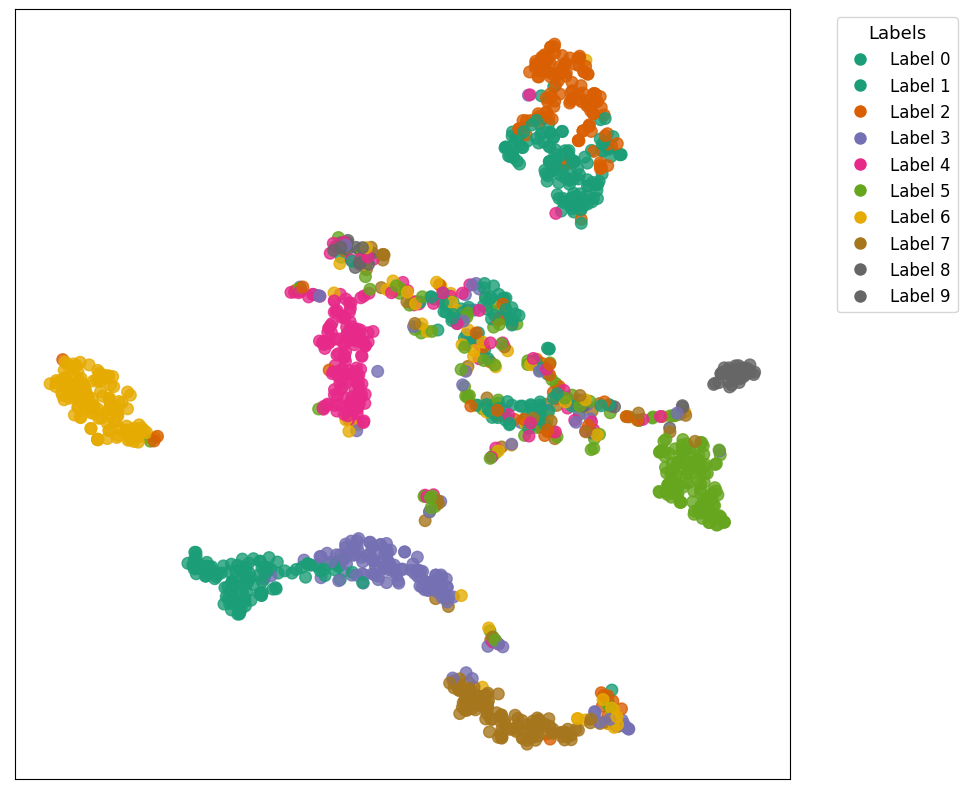

In [76]:
# Example usage
print(f'Embedding shape: {len(train_embeddings)}')
color = np.array(train_labels)
print(color)
print(color.shape)
unique_colors = np.unique(color)
print(f'Unique labels: {unique_colors}')

visualize(train_embeddings, color)

c:\env\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\env\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
c:\env\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\env\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


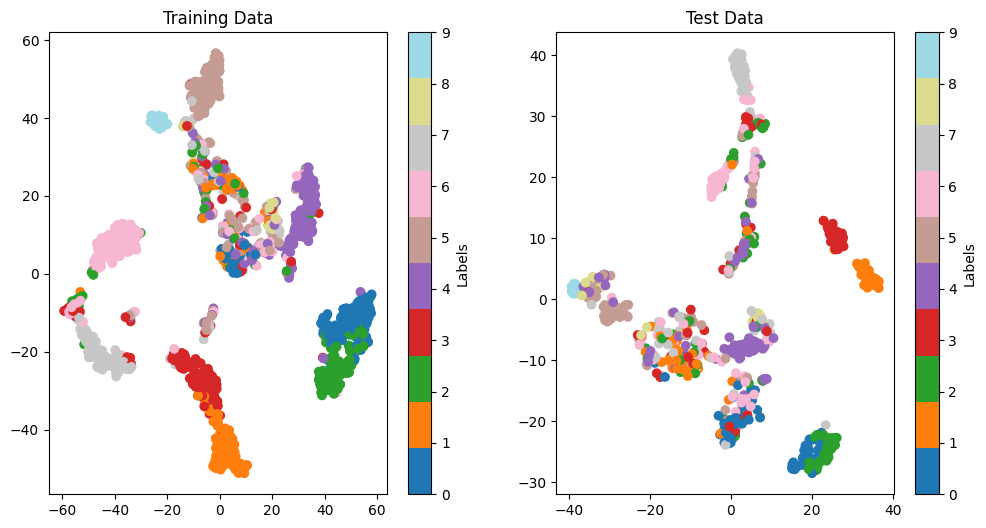

In [77]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import numpy as np

# Convert tensors to numpy arrays
h = torch.stack(tensor_train_embeddings).detach().cpu().numpy()
h1 = torch.stack(tensor_test_embeddings).detach().cpu().numpy()
color = np.array(train_labels)
color1 = np.array(test_labels)

# Apply TSNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)  # Set random_state for reproducibility
z = tsne.fit_transform(h)
y = tsne.fit_transform(h1)

# Define color maps and labels
unique_labels_train = np.unique(color)
unique_labels_test = np.unique(color1)

# Create a color map that can handle more unique labels
colormap_train = plt.cm.get_cmap('tab20', len(unique_labels_train))
colormap_test = plt.cm.get_cmap('tab20', len(unique_labels_test))

# Create subplots
plt.figure(figsize=(12, 6))

# Plot the training data
plt.subplot(1, 2, 1)
scatter_train = plt.scatter(z[:, 0], z[:, 1], c=color, cmap=colormap_train, marker='o')
plt.title('Training Data')
cbar = plt.colorbar(scatter_train, ticks=np.arange(len(unique_labels_train)))
cbar.set_label('Labels')
cbar.set_ticks(np.arange(len(unique_labels_train)))
cbar.set_ticklabels([str(label) for label in unique_labels_train])

# Plot the test data
plt.subplot(1, 2, 2)
scatter_test = plt.scatter(y[:, 0], y[:, 1], c=color1, cmap=colormap_test, marker='o')
plt.title('Test Data')
cbar = plt.colorbar(scatter_test, ticks=np.arange(len(unique_labels_test)))
cbar.set_label('Labels')
cbar.set_ticks(np.arange(len(unique_labels_test)))
cbar.set_ticklabels([str(label) for label in unique_labels_test])

plt.show()


In [78]:
for epoch in range(5):
    train_loss, train_accuracy, train_precision, train_recall, train_f1 = train(training_loader)
    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")
for epoch in range(5):
    train_loss, train_accuracy,train_embeddings,train_labels, train_precision, train_recall, train_f1 = test(training_loader)

    test_loss,test_accuracy,test_embeddings,test_labels, test_precision, test_recall, test_f1 = test(Testing_loader)
    print(f"Epoch {epoch+1} - Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.84it/s]


Epoch 1 - Train Loss: 0.2322, Accuracy: 0.9217, Precision: 0.9225, Recall: 0.9217, F1 Score: 0.9216


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.10it/s]


Epoch 2 - Train Loss: 0.1919, Accuracy: 0.9123, Precision: 0.9122, Recall: 0.9123, F1 Score: 0.9120


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.19it/s]


Epoch 3 - Train Loss: 0.1646, Accuracy: 0.9415, Precision: 0.9415, Recall: 0.9415, F1 Score: 0.9414


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.99it/s]


Epoch 4 - Train Loss: 0.1642, Accuracy: 0.9330, Precision: 0.9335, Recall: 0.9330, F1 Score: 0.9331


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.17it/s]


Epoch 5 - Train Loss: 0.1867, Accuracy: 0.9292, Precision: 0.9298, Recall: 0.9292, F1 Score: 0.9294


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 34.68it/s]


Epoch 1 - Test Loss: 0.2457, Accuracy: 0.8837, Precision: 0.9162, Recall: 0.8837, F1 Score: 0.8712


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 32.01it/s]


Epoch 2 - Test Loss: 0.3683, Accuracy: 0.8306, Precision: 0.8660, Recall: 0.8306, F1 Score: 0.8179


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 33.58it/s]


Epoch 3 - Test Loss: 0.3917, Accuracy: 0.8372, Precision: 0.8838, Recall: 0.8372, F1 Score: 0.8118


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 31.81it/s]


Epoch 4 - Test Loss: 0.4343, Accuracy: 0.8439, Precision: 0.8924, Recall: 0.8439, F1 Score: 0.8278


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 36.41it/s]

Epoch 5 - Test Loss: 0.6008, Accuracy: 0.7741, Precision: 0.7888, Recall: 0.7741, F1 Score: 0.7557


In [84]:
import numpy as np
from sklearn.metrics import accuracy_score, silhouette_score, adjusted_rand_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

def classifier():
    print("Training classifier...")

    classifiers = [
        SVC(C=1.0, kernel='rbf'),
        RandomForestClassifier(n_estimators=100),
        GradientBoostingClassifier(n_estimators=100),
        KNeighborsClassifier(n_neighbors=5)
    ]

    # Convert embeddings to numpy arrays and ensure they are 2D
    X_train = np.array([np.ravel(embedding) for embedding in train_embeddings])
    X_test = np.array([np.ravel(embedding) for embedding in test_embeddings])
    Y_train = np.array(train_labels)
    Y_test = np.array(test_labels)
    
    accuracies = {}

    for clf in classifiers:
        print(f"Testing with {clf.__class__.__name__}")
        clf.fit(X_train, Y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(Y_test, y_pred)
        accuracies[clf.__class__.__name__] = accuracy
        print(f"Accuracy with {clf.__class__.__name__}: {accuracy:.5f}")

    return accuracies

def clustering():
    print("Performing clustering tasks...")

    # Convert embeddings to numpy arrays and ensure they are 2D
    X_train = np.array([np.ravel(embedding) for embedding in train_embeddings])
    X_test = np.array([np.ravel(embedding) for embedding in test_embeddings])
    Y_train = np.array(train_labels)
    Y_test = np.array(test_labels)

    clustering_algorithms = [
        KMeans(n_clusters=len(np.unique(Y_train))),
        DBSCAN(eps=0.5, min_samples=5),
        AgglomerativeClustering(n_clusters=len(np.unique(Y_train)))
    ]
    
    cluster_scores = {}

    for algo in clustering_algorithms:
        print(f"Testing with {algo.__class__.__name__}")
        algo.fit(X_train)
        if hasattr(algo, 'labels_'):
            cluster_labels = algo.labels_
        else:
            raise NotImplementedError(f"{algo.__class__.__name__} does not have a labels_ attribute")

        # Check number of unique clusters
        unique_clusters = np.unique(cluster_labels)
        num_clusters = len(unique_clusters)

        # Print number of clusters
        print(f"Number of clusters for {algo.__class__.__name__}: {num_clusters}")

        if num_clusters > 1:
            silhouette_avg = silhouette_score(X_train, cluster_labels)
            rand_score = adjusted_rand_score(Y_train, cluster_labels)
            cluster_scores[algo.__class__.__name__] = {
                'Silhouette Score': silhouette_avg,
                'Adjusted Rand Index': rand_score
            }
            print(f"{algo.__class__.__name__} - Silhouette Score: {silhouette_avg:.5f}, Adjusted Rand Index: {rand_score:.5f}")
        else:
            print(f"{algo.__class__.__name__} - Cannot compute scores, only one cluster found.")

    return cluster_scores

# Example loop for training over multiple epochs
for epoch in range(1, 5):
    val_accuracies = classifier()
    for clf_name, acc in val_accuracies.items():
        print(f'Epoch {epoch}, {clf_name}: Val Accuracy: {acc:.5f}')

    cluster_results = clustering()
    for algo_name, scores in cluster_results.items():
        print(f'Epoch {epoch}, {algo_name}: Silhouette Score: {scores["Silhouette Score"]:.5f}, Adjusted Rand Index: {scores["Adjusted Rand Index"]:.5f}')


Training classifier...
Testing with SVC
Accuracy with SVC: 0.59265
Testing with RandomForestClassifier
Accuracy with RandomForestClassifier: 0.61562
Testing with GradientBoostingClassifier
Accuracy with GradientBoostingClassifier: 0.59112
Testing with KNeighborsClassifier
Accuracy with KNeighborsClassifier: 0.61103
Epoch 1, SVC: Val Accuracy: 0.59265
Epoch 1, RandomForestClassifier: Val Accuracy: 0.61562
Epoch 1, GradientBoostingClassifier: Val Accuracy: 0.59112
Epoch 1, KNeighborsClassifier: Val Accuracy: 0.61103
Performing clustering tasks...
Testing with KMeans
Number of clusters for KMeans: 10
KMeans - Silhouette Score: 0.44917, Adjusted Rand Index: 0.39110
Testing with DBSCAN
Number of clusters for DBSCAN: 1
DBSCAN - Cannot compute scores, only one cluster found.
Testing with AgglomerativeClustering
Number of clusters for AgglomerativeClustering: 10
AgglomerativeClustering - Silhouette Score: 0.43071, Adjusted Rand Index: 0.40576
Epoch 1, KMeans: Silhouette Score: 0.44917, Adjuste